In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline               

In [403]:
# create train,test dataframes
train=pd.read_csv('train_bm.csv')
test=pd.read_csv('test_bm.csv')
submission=pd.read_csv('sample_submission.csv')

In [3]:
print('shape of data frames:',train.shape,test.shape)

shape of data frames: (8523, 12) (5681, 11)


In [252]:
train_copy=train.copy()
test_copy=test.copy()

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
train.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
test.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [10]:
train.describe()

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

In [238]:
cat_cols=[x for x in train.dtypes.index if train.dtypes[x]=='object']
print(cat_cols)

['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [239]:
cat_cols=[x for x in cat_cols if x not in ['Item_Identifier','Outlet_Identifier']]
for i in cat_cols:
    print(f'\033[4m \nfrequency count of {i}\033[0m')
    print(train[i].value_counts())

 
frequency count of Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
 
frequency count of Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
 
frequency count of Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64
 
frequency count of Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64
 
frequency count of Outlet_Type
Supermarket Type1    5577
Grocery

In [27]:
import sweetviz as sv
eda=sv.analyze(train)
eda.show_html('eda.html')

                                             |          | [  0%]   00:00 -> (? left)

Report eda.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [404]:
# Lets Treat Missing Values 
Item_Weight_avg_per_itemtype= pd.pivot_table(values='Item_Weight',index='Item_Type',data=train)
missing=train.Item_Weight.isna()
train.loc[missing,'Item_Weight']=train.loc[missing,'Item_Type'].apply(lambda x: Item_Weight_avg_per_itemtype.loc[x])

In [405]:
Item_Weight_avg_per_itemtype= test.groupby('Item_Type')['Item_Weight'].mean()
missing=test.Item_Weight.isna()
test.loc[missing,'Item_Weight']=test.loc[missing,'Item_Type'].apply(lambda x: Item_Weight_avg_per_itemtype.loc[x])

In [406]:
outlet_mode = train.groupby('Outlet_Type')['Outlet_Size'].apply(lambda x: x.mode()[0])
nulls=train.Outlet_Size.isna()
train.loc[nulls,"Outlet_Size"]=train.loc[nulls,'Outlet_Type'].apply(lambda x: outlet_mode.loc[x])

In [407]:
outlet_mode = test.groupby('Outlet_Type')['Outlet_Size'].apply(lambda x: x.mode()[0])
nulls=test.Outlet_Size.isna()
test.loc[nulls,"Outlet_Size"]=test.loc[nulls,'Outlet_Type'].apply(lambda x: outlet_mode.loc[x])

In [244]:
train.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [408]:
# there are duplicates in ITem_Fat_Content, lets treat them
mapping={'Low Fat':'LF', 'Regular':'R', 'low fat':'LF', 'LF':'LF', 'reg':'R'}
train['Item_Fat_Content']=train.Item_Fat_Content.map(mapping)
test['Item_Fat_Content']=test.Item_Fat_Content.map(mapping)

In [409]:
train.Item_Fat_Content.unique(),test.Item_Fat_Content.unique()

(array(['LF', 'R'], dtype=object), array(['LF', 'R'], dtype=object))

In [410]:
train.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [248]:
test.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

 # Univariate analysis

In [581]:
import sweetviz as sv
eda= sv.analyze(train)
eda.show_html('edal.html') 

                                             |          | [  0%]   00:00 -> (? left)

Report edal.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Fruits and Vegetables'),
  Text(1, 0, 'Snack Foods'),
  Text(2, 0, 'Household'),
  Text(3, 0, 'Frozen Foods'),
  Text(4, 0, 'Dairy'),
  Text(5, 0, 'Canned'),
  Text(6, 0, 'Baking Goods'),
  Text(7, 0, 'Health and Hygiene'),
  Text(8, 0, 'Meat'),
  Text(9, 0, 'Soft Drinks'),
  Text(10, 0, 'Breads'),
  Text(11, 0, 'Hard Drinks'),
  Text(12, 0, 'Starchy Foods'),
  Text(13, 0, 'Others'),
  Text(14, 0, 'Breakfast'),
  Text(15, 0, 'Seafood')])

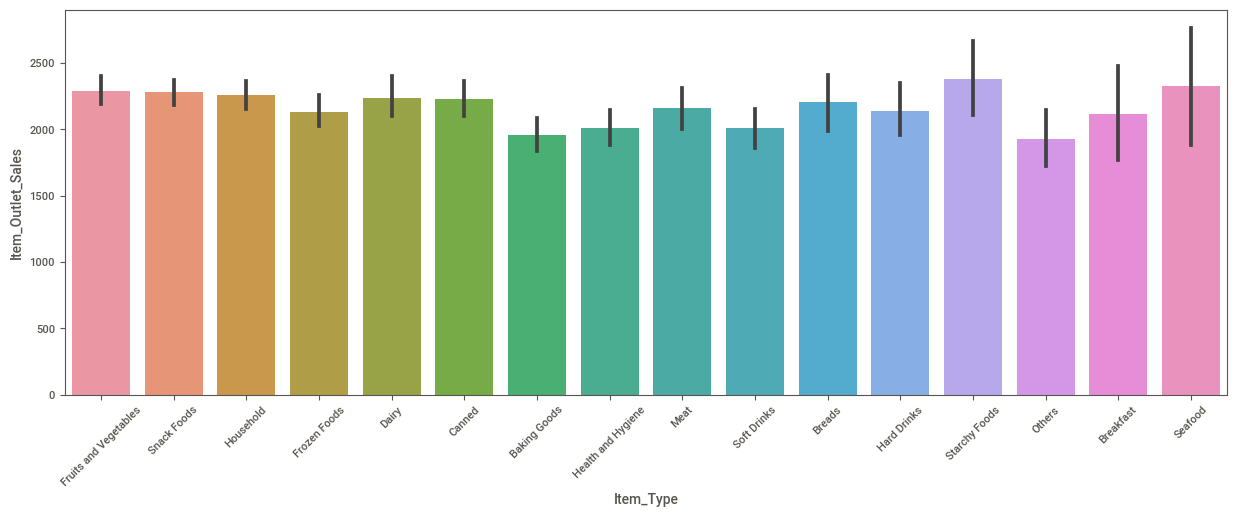

In [50]:
plt.figure(figsize=(15,5))
total_outlet_sales_per_item=train.groupby('Item_Type')['Item_Outlet_Sales'].sum().sort_values(ascending=False).index
sns.barplot(x='Item_Type',y='Item_Outlet_Sales',data=train,order=total_outlet_sales_per_item)
plt.xticks(rotation=45)

<Axes: xlabel='Outlet_Identifier', ylabel='Item_Outlet_Sales'>

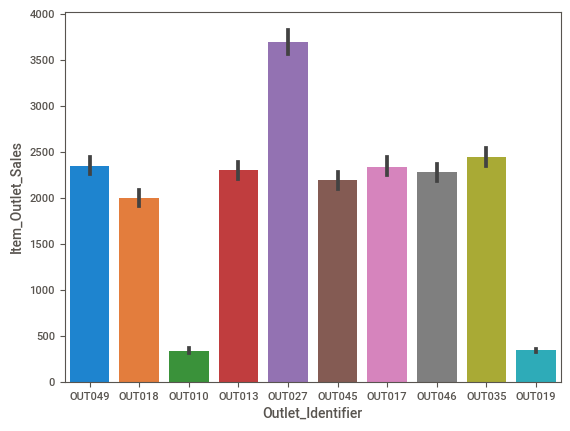

In [51]:
sns.barplot(x='Outlet_Identifier',y='Item_Outlet_Sales',data=train)

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

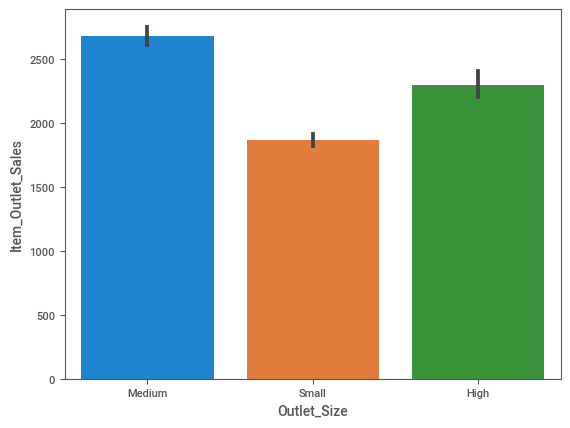

In [52]:
sns.barplot(x='Outlet_Size',y='Item_Outlet_Sales',data=train)

<Axes: xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

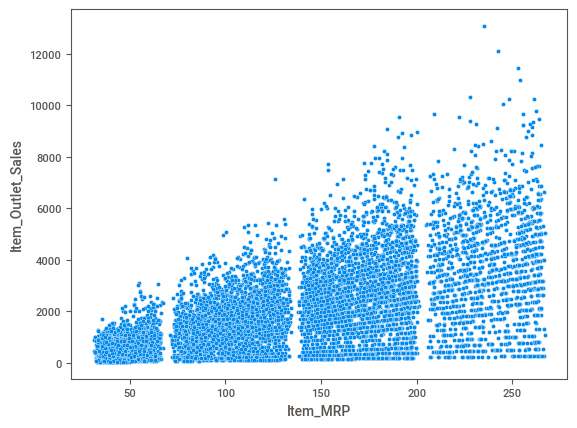

In [53]:
sns.scatterplot(x='Item_MRP',y='Item_Outlet_Sales',data=train)

<Axes: xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>

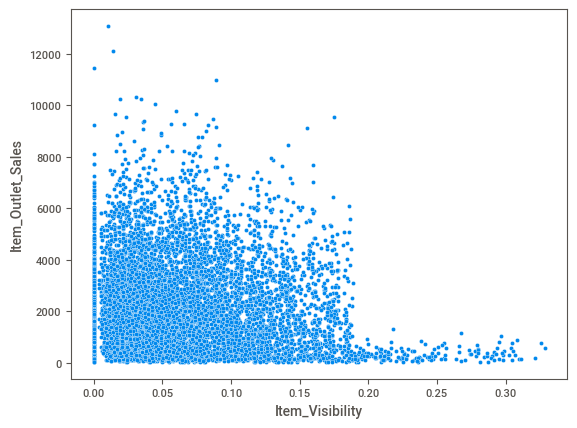

In [54]:
 sns.scatterplot(x='Item_Visibility',y='Item_Outlet_Sales',data=train)

<Axes: xlabel='Item_Weight', ylabel='Item_Outlet_Sales'>

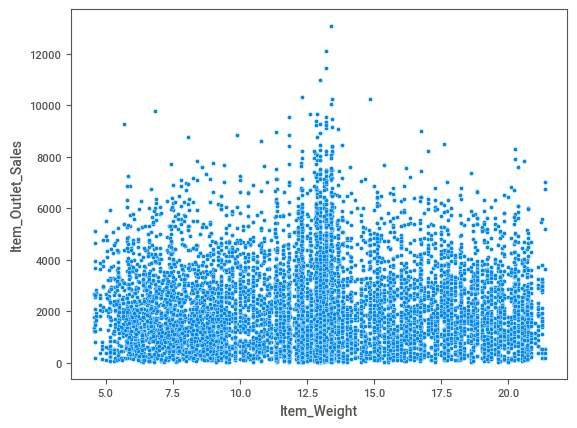

In [55]:
sns.scatterplot(x='Item_Weight',y='Item_Outlet_Sales',data=train)

In [411]:
train['Item_Visibility']=np.where(train['Item_Visibility']==0,'Nan',train['Item_Visibility']).astype(float)
train['Item_Identifier']=train['Item_Identifier'].str.slice(0,2)
train['Years']=2013-train['Outlet_Establishment_Year']
train['price/wt']=train['Item_MRP']/train['Item_Weight']
train['Outlet_Size']=np.where(train['Outlet_Identifier']=='OUT010','Small',train['Outlet_Size'])
train['Outlet_Size']=np.where(train['Outlet_Identifier']=='OUT017','Medium',train['Outlet_Size'])
train['Outlet_Size']=np.where(train['Outlet_Identifier']=='OUT045','Medium',train['Outlet_Size'])
train['Item_MRP2']=np.where(train['Item_MRP']<69,'A',np.where(train['Item_MRP']<136,'B',np.where(train['Item_MRP']<203,'C','D')))
train['Item_Visibility2']=np.where(train['Item_Visibility']<0.19,1,0)


test['Item_Visibility']=np.where(test['Item_Visibility']==0,'Nan',test['Item_Visibility']).astype(float)
test['Item_Identifier']=test['Item_Identifier'].str.slice(0,2)
test['Years']=2013-test['Outlet_Establishment_Year']
test['price/wt']=test['Item_MRP']/test['Item_Weight']
test['Outlet_Size']=np.where(test['Outlet_Identifier']=='OUT010','Small',test['Outlet_Size'])
test['Outlet_Size']=np.where(test['Outlet_Identifier']=='OUT017','Medium',test['Outlet_Size'])
test['Outlet_Size']=np.where(test['Outlet_Identifier']=='OUT045','Medium',test['Outlet_Size'])
test['Item_MRP2']=np.where(test['Item_MRP']<69,'A',np.where(test['Item_MRP']<136,'B',np.where(test['Item_MRP']<203,'C','D')))
test['Item_Visibility2']=np.where(test['Item_Visibility']<0.19,1,0)


In [266]:
train

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0                 FD        9.300               LF         0.016047   
1                 DR        5.920                R         0.019278   
2                 FD       17.500               LF         0.016760   
3                 FD       19.200                R              NaN   
4                 NC        8.930               LF              NaN   
...              ...          ...              ...              ...   
8518              FD        6.865               LF         0.056783   
8519              FD        8.380                R         0.046982   
8520              NC       10.600               LF         0.035186   
8521              FD        7.210                R         0.145221   
8522              DR       14.800               LF         0.044878   

                  Item_Type  Item_MRP Outlet_Identifier  \
0                     Dairy  249.8092            OUT049   
1               Soft Drinks   48.2692            OUT018   
2                      Meat  141.6180            OUT049   
3     Fruits and Vegetables  182.0950            OUT010   
4                 Household   53.8614            OUT013   
...                     ...       ...               ...   
8518            Snack Foods  214.5218            OUT013   
8519           Baking Goods  108.1570            OUT045   
8520     Health and Hygiene   85.1224            OUT035   
8521            Snack Foods  103.1332            OUT018   
8522            Soft Drinks   75.4670            OUT046   

      Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                          1999      Medium               Tier 1   
1                          2009      Medium               Tier 3   
2                          1999      Medium               Tier 1   
3                          1998       Small               Tier 3   
4                          1987        High               Tier 3   
...                         ...         ...                  ...   
8518                       1987        High               Tier 3   
8519                       2002      Medium               Tier 2   
8520                       2004       Small               Tier 2   
8521                       2009      Medium               Tier 3   
8522                       1997       Small               Tier 1   

            Outlet_Type  Item_Outlet_Sales  Years   price/wt Item_MRP2  \
0     Supermarket Type1          3735.1380     14  26.861204         D   
1     Supermarket Type2           443.4228      4   8.153581         A   
2     Supermarket Type1          2097.2700     14   8.092457         C   
3         Grocery Store           732.3800     15   9.484115         C   
4     Supermarket Type1           994.7052     26   6.031512         A   
...                 ...                ...    ...        ...       ...   
8518  Supermarket Type1          2778.3834     26  31.248623         D   
8519  Supermarket Type1           549.2850     11  12.906563         B   
8520  Supermarket Type1          1193.1136      9   8.030415         B   
8521  Supermarket Type2          1845.5976      4  14.304189         B   
8522  Supermarket Type1           765.6700     16   5.099122         B   

      Item_Visibility2  
0                    1  
1                    1  
2                    1  
3                    0  
4                    0  
...                ...  
8518                 1  
8519                 1  
8520                 1  
8521                 1  
8522                 1  

[8523 rows x 16 columns]

<Axes: >

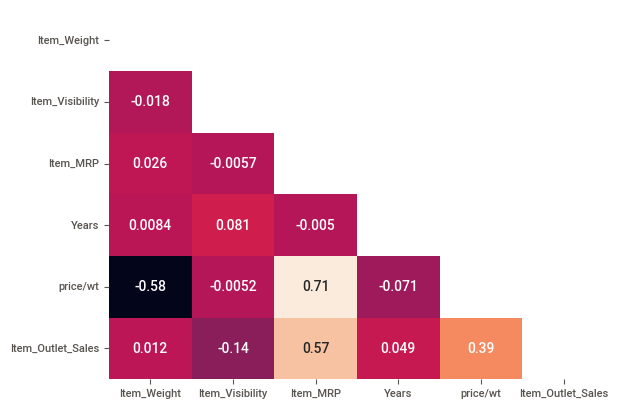

In [79]:
corr=train[['Item_Weight','Item_Visibility','Item_MRP','Years','price/wt','Item_Outlet_Sales']].corr()
mask=np.triu(np.ones_like(corr)) #hides lower traingle of matrix
sns.heatmap(corr,annot=True,mask=mask,cbar=False)

In [412]:
y=train['Item_Outlet_Sales']
x=train.drop(['Item_Outlet_Sales','Outlet_Establishment_Year'],axis=1)
test.drop('Outlet_Establishment_Year',1,inplace=True)

In [413]:
test=test.apply(lambda x: x.fillna(x.mean())if x.dtype.kind in 'biufc'else x.fillna('NA')) # Binayr Integer Unsigned bit(>=0) Float Complex Float
x=x.apply(lambda x: x.fillna(x.mean())if x.dtype.kind in 'biufc'else x.fillna(x.mode()))

In [85]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [182]:
cols=['Item_Identifier','Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_MRP2']
for i in cols:
    x[i]=le.fit_transform(x[i])
    test[i]=le.fit_transform(test[i])

In [177]:
x

Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                   1        9.300                 0         0.016047   
1                   0        5.920                 1         0.019278   
2                   1       17.500                 0         0.016760   
3                   1       19.200                 1         0.070482   
4                   2        8.930                 0         0.070482   
...               ...          ...               ...              ...   
8518                1        6.865                 0         0.056783   
8519                1        8.380                 1         0.046982   
8520                2       10.600                 0         0.035186   
8521                1        7.210                 1         0.145221   
8522                0       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Size  \
0             4  249.8092                  9            1   
1            14   48.2692                  3            1   
2            10  141.6180                  9            1   
3             6  182.0950                  0            2   
4             9   53.8614                  1            0   
...         ...       ...                ...          ...   
8518         13  214.5218                  1            0   
8519          0  108.1570                  7            2   
8520          8   85.1224                  6            2   
8521         13  103.1332                  3            1   
8522         14   75.4670                  8            2   

      Outlet_Location_Type  Outlet_Type  Years   price/wt  Item_MRP2  \
0                        0            1     14  26.861204          3   
1                        2            2      4   8.153581          0   
2                        0            1     14   8.092457          2   
3                        2            0     15   9.484115          2   
4                        2            1     26   6.031512          0   
...                    ...          ...    ...        ...        ...   
8518                     2            1     26  31.248623          3   
8519                     1            1     11  12.906563          1   
8520                     1            1      9   8.030415          1   
8521                     2            2      4  14.304189          1   
8522                     0            1     16   5.099122          1   

      Item_Visibility2  
0                    1  
1                    1  
2                    1  
3                    0  
4                    0  
...                ...  
8518                 1  
8519                 1  
8520                 1  
8521                 1  
8522                 1  

[8523 rows x 14 columns]

In [183]:
test

Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                   1     20.75000                 0         0.007565   
1                   1      8.30000                 1         0.038428   
2                   2     14.60000                 0         0.099575   
3                   1      7.31500                 0         0.015388   
4                   1     12.95504                 1         0.118599   
...               ...          ...               ...              ...   
5676                1     10.50000                 1         0.013496   
5677                1      7.60000                 1         0.142991   
5678                2     10.00000                 0         0.073529   
5679                1     15.30000                 1         0.070036   
5680                1      9.50000                 1         0.104720   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Size  \
0            13  107.8622                  9            1   
1             4   87.3198                  2            2   
2            11  241.7538                  0            2   
3            13  155.0340                  2            2   
4             4  234.2300                  5            1   
...         ...       ...                ...          ...   
5676         13  141.3154                  8            2   
5677         15  169.1448                  3            1   
5678          8  118.7440                  7            2   
5679          3  214.6218                  2            2   
5680          3   79.7960                  7            2   

      Outlet_Location_Type  Outlet_Type  Years   price/wt  Item_MRP2  \
0                        0            1     14   5.198178          1   
1                        1            1      6  10.520458          1   
2                        2            0     15  16.558479          3   
3                        1            1      6  21.193985          2   
4                        2            3     28  18.080222          3   
...                    ...          ...    ...        ...        ...   
5676                     0            1     16  13.458610          2   
5677                     2            2      4  22.255895          2   
5678                     1            1     11  11.874400          1   
5679                     1            1      6  14.027569          3   
5680                     1            1     11   8.399579          1   

      Item_Visibility2  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  
...                ...  
5676                 1  
5677                 1  
5678                 1  
5679                 0  
5680                 1  

[5681 rows x 14 columns]

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
train_x, val_x, train_y, val_y = train_test_split(x,y, test_size=0.15,random_state=42)
model=LinearRegression()
model.fit(train_x,train_y)
pred_train=model.predict(train_x)
rmse=MSE(train_y,pred_train,squared=False)
rmse

1211.6710516278013

In [90]:
pred_val=model.predict(val_x)
rmse=MSE(val_y,pred_val,squared=False)
rmse

1145.7922815474099

In [657]:
pred_test=model.predict(test)

In [660]:
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('LinearReg.csv',index=False) # we got rmse 1269

Item_Identifier Outlet_Identifier  Item_Outlet_Sales
0           FDW58            OUT049        1991.004415
1           FDW14            OUT017        1083.058514
2           NCN55            OUT010        2244.554173
3           FDQ58            OUT017        2111.991678
4           FDY38            OUT027        5066.710732

<Axes: title={'center': 'Model Coefficients'}>

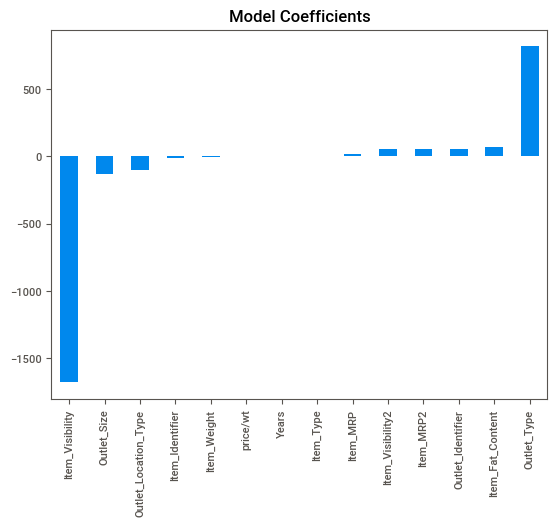

In [91]:
coef=pd.Series(model.coef_,x.columns).sort_values()
coef.plot(kind='bar',title='Model Coefficients')

In [92]:
print(model.intercept_)

-849.4331005224612


In [96]:
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import GridSearchCV
param_grid={'alpha':[0.001,0.01,0.1,1,10,100]}
ridge=Ridge()
Lasso=Lasso()
grid_search=GridSearchCV(ridge,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(train_x,train_y)
best_alpha=grid_search.best_params_['alpha']
print('best alpha:',best_alpha)

best alpha: 1


In [97]:
grid_search.best_score_

-1476979.1392807602

In [98]:
grid_search=GridSearchCV(Lasso,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(train_x,train_y)
best_alpha=grid_search.best_params_['alpha']
best_alpha

0.1

In [99]:
grid_search.best_score_

-1476992.684366904

In [100]:
ridge=Ridge(alpha=1)
ridge.fit(train_x,train_y)
pred_train=ridge.predict(train_x)
rmse=MSE(train_y,pred_train,squared=False)
rmse

1211.6802208736635

In [101]:
pred_val=ridge.predict(val_x)
rmse=MSE(val_y,pred_val,squared=False)
rmse

1145.7685903982751

In [697]:
pred_test=ridge.predict(test)

<Axes: >

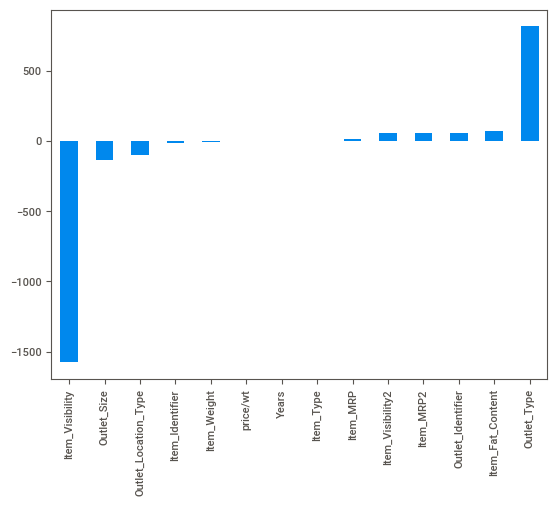

In [104]:
coefR=pd.Series(ridge.coef_,x.columns).sort_values(ascending=True)
coefR.plot(kind='bar')

In [701]:
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('Ridge.csv',index=False) # we got rmse 1268.94

In [105]:
from sklearn.linear_model import Lasso
Lasso=Lasso(alpha=0.1)
Lasso.fit(train_x,train_y)
pred_train=Lasso.predict(train_x)
rmse=MSE(train_y,pred_train,squared=False)
rmse

1211.673033121563

In [106]:
pred_val=Lasso.predict(val_x)
rmse=MSE(val_y,pred_val,squared=False)
rmse

1145.7702513715049

In [714]:
pred_test=Lasso.predict(test)

<Axes: >

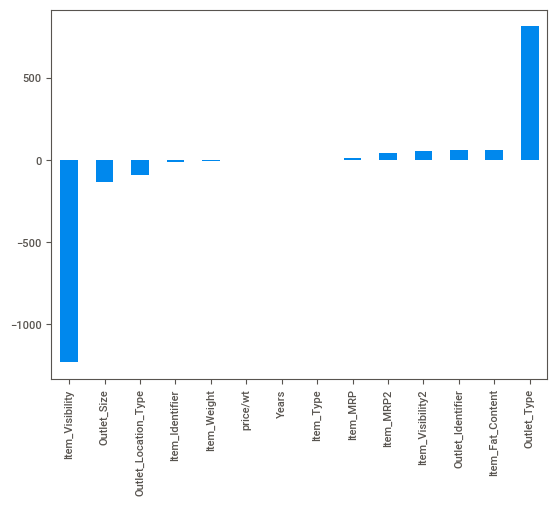

In [715]:
coefR=pd.Series(Lasso.coef_,x.columns).sort_values()
coefR.plot(kind='bar')

In [717]:
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('Lasso.csv',index=False) # we got rmse 1268.86

In [111]:
from sklearn.model_selection import KFold
i=1
kf = KFold(n_splits=5,random_state=42,shuffle=True) # splitting the ds into 5 folds
for x_index,test_index in kf.split(x,y):#kf.split generates indices for different folds and stored in x_index and test_index
        print('n-{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = x.iloc[x_index],x.iloc[test_index]#splitting data into train and validation sets
        ytr,yvl = y.iloc[x_index],y.iloc[test_index]
        model = LinearRegression()
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        rmse = MSE(yvl,pred_val,squared=False)
        print('RMSE Score',rmse)
        i+=1



n-1 of kfold 5
RMSE Score 1140.9837952992689
n-2 of kfold 5
RMSE Score 1202.8429085682665
n-3 of kfold 5
RMSE Score 1207.6839616280163
n-4 of kfold 5
RMSE Score 1229.2720313050334
n-5 of kfold 5
RMSE Score 1238.9047023105056


In [729]:
pred_test=model.predict(test)
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('KFold.csv',index=False) # we got rmse 1268.344

In [41]:
from sklearn.model_selection import KFold
i=1
kf = KFold(n_splits=5,random_state=42,shuffle=True) # splitting the ds into 5 folds
for x_index,test_index in kf.split(x,y):#kf.split generates indices for different folds and stored in train_index and test_index
        print('n-{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = x.iloc[x_index],x.iloc[test_index]#splitting data into train and validation sets
        ytr,yvl = y.iloc[x_index],y.iloc[test_index]
        model = Ridge(alpha=1)
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        rmse = MSE(yvl,pred_val,squared=False)
        print('RMSE Score',rmse)
        i+=1



n-1 of kfold 5
RMSE Score 1140.8256743526913
n-2 of kfold 5
RMSE Score 1202.7045515102038
n-3 of kfold 5
RMSE Score 1207.6459269765614
n-4 of kfold 5
RMSE Score 1229.3784743502792
n-5 of kfold 5
RMSE Score 1239.0889559595498


In [732]:
pred_test=model.predict(test)
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('RidgeKFold.csv',index=False) # we got rmse 1268.34

In [42]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
i=1
kf = KFold(n_splits=5,random_state=42,shuffle=True) # splitting the ds into 5 folds
for x_index,test_index in kf.split(x,y):#kf.split generates indices for different folds and stored in train_index and test_index
        print('n-{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = x.iloc[x_index],x.iloc[test_index]#splitting data into train and validation sets
        ytr,yvl = y.iloc[x_index],y.iloc[test_index]
        model = Lasso(alpha=0.1)
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        rmse = MSE(yvl,pred_val,squared=False)
        print('RMSE Score',rmse)
        i+=1



n-1 of kfold 5
RMSE Score 1140.931786973072
n-2 of kfold 5
RMSE Score 1202.7560111606156
n-3 of kfold 5
RMSE Score 1207.6796312708075
n-4 of kfold 5
RMSE Score 1229.324795441285
n-5 of kfold 5
RMSE Score 1238.9869701712921


In [736]:
pred_test=model.predict(test)
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('LassoKFold.csv',index=False) # we got rmse 1268.33

In [112]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
i=1
kf = KFold(n_splits=5,random_state=1,shuffle=True) # splitting the ds into 5 folds
for x_index,test_index in kf.split(x,y):#kf.split generates indices for different folds and stored in train_index and test_index
        print('n-{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = x.iloc[x_index],x.iloc[test_index]#splitting data into train and validation sets
        ytr,yvl = y.iloc[x_index],y.iloc[test_index]
        model = DecisionTreeRegressor(max_depth=5,random_state=1,min_samples_split=2,min_samples_leaf=3)
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        rmse = MSE(yvl,pred_val,squared=False)
        print('RMSE Score',rmse)
        i+=1



n-1 of kfold 5
RMSE Score 1108.6388322644016
n-2 of kfold 5
RMSE Score 1093.2669476573708
n-3 of kfold 5
RMSE Score 1093.1758468011678
n-4 of kfold 5
RMSE Score 1021.4486538661753
n-5 of kfold 5
RMSE Score 1114.5112935136933


In [113]:
from sklearn.model_selection import GridSearchCV
param_grid={'max_depth':list(range(1,10)),
           'random_state':list(range(1,50,2)),
           'min_samples_split': list(range(10,30,10)),
           'min_samples_leaf':list(range(5,20,5))}
model=DecisionTreeRegressor()
grid_search=GridSearchCV(model,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(train_x,train_y)
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'random_state': 1}

In [763]:
grid_search.best_score_

-1212778.1969973862

In [769]:
pred_test=model.predict(test)
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('DecisionTreeReg.csv',index=False) # we got rmse 1162.04

In [128]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
i=1
kf = KFold(n_splits=5,random_state=1,shuffle=True) # splitting the ds into 5 folds
for x_index,test_index in kf.split(x,y):#kf.split generates indices for different folds and stored in train_index and test_index
        print('n-{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = x.iloc[x_index],x.iloc[test_index]#splitting data into train and validation sets
        ytr,yvl = y.iloc[x_index],y.iloc[test_index]
        model = RandomForestRegressor(max_depth=5,n_estimators=61,random_state=1,min_samples_split=2,min_samples_leaf=3)
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        rmse = MSE(yvl,pred_val,squared=False)
        print('RMSE Score',rmse)
        i+=1



n-1 of kfold 5
RMSE Score 1092.417021773439
n-2 of kfold 5
RMSE Score 1087.3281704317371
n-3 of kfold 5
RMSE Score 1087.064660066753
n-4 of kfold 5
RMSE Score 1013.5722130691363
n-5 of kfold 5
RMSE Score 1110.5404526006753


In [125]:
param_grid={'max_depth':list(range(1,20)),
           'n_estimators':list(range(1,100,20))}
model=RandomForestRegressor()
grid_search=GridSearchCV(model,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(train_x,train_y)
grid_search.best_params_

{'max_depth': 5, 'n_estimators': 61}

In [793]:
pred_test=model.predict(test)
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('RandomForestReg.csv',index=False) # we got rmse 1157.46

In [46]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_scaled=sc.fit_transform(x)
test_scaled=sc.fit_transform(test)

In [47]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
i=1
kf = KFold(n_splits=5,random_state=1,shuffle=True) # splitting the ds into 5 folds
for x_index,test_index in kf.split(x_scaled,y):#kf.split generates indices for different folds and stored in train_index and test_index
        print('n-{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = x_scaled[x_index],x_scaled[test_index]#splitting data into train and validation sets
        ytr,yvl = y.iloc[x_index],y.iloc[test_index]
        model = RandomForestRegressor(max_depth=5,n_estimators=41,random_state=1,min_samples_split=2,min_samples_leaf=3)
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        rmse = MSE(yvl,pred_val,squared=False)
        print('RMSE Score',rmse)
        i+=1



n-1 of kfold 5
RMSE Score 1092.062195321248
n-2 of kfold 5
RMSE Score 1087.136025723229
n-3 of kfold 5
RMSE Score 1087.3053065914874
n-4 of kfold 5
RMSE Score 1013.838363577607
n-5 of kfold 5
RMSE Score 1111.0834206060094


In [828]:
param_grid={'max_depth':list(range(1,10)),
           'n_estimators':list(range(1,100,20))}
model=RandomForestRegressor()
grid_search=GridSearchCV(model,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(xtr,ytr)
grid_search.best_params_

{'max_depth': 5, 'n_estimators': 41}

In [831]:
pred_test=model.predict(test_scaled)
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('RandomForestRegScaled.csv',index=False) # we got rmse 1157.92

In [966]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
i=1
kf = KFold(n_splits=5,random_state=1,shuffle=True) # splitting the ds into 5 folds
for x_index,test_index in kf.split(x,y):#kf.split generates indices for different folds and stored in train_index and test_index
        print('n-{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = x.iloc[x_index],x.iloc[test_index]#splitting data into train and validation sets
        ytr,yvl = y.iloc[x_index],y.iloc[test_index]
        model = GradientBoostingRegressor(max_depth=5,n_estimators=70,random_state=1,min_samples_split=2,min_samples_leaf=3,learning_rate=0.05,subsample=0.8,alpha=0.9)
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        rmse = MSE(yvl,pred_val,squared=False)
        print('RMSE Score',rmse)
        i+=1



n-1 of kfold 5
RMSE Score 1101.8517147378243
n-2 of kfold 5
RMSE Score 1083.5330174716194
n-3 of kfold 5
RMSE Score 1095.8001027818948
n-4 of kfold 5
RMSE Score 1012.4819745865328
n-5 of kfold 5
RMSE Score 1118.2936794994955


In [865]:
pred_test=model.predict(test)
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('GradientBoostingReg.csv',index=False) # we got rmse 1158

In [964]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
i=1
kf = KFold(n_splits=5,random_state=1,shuffle=True) # splitting the ds into 5 folds
for x_index,test_index in kf.split(x,y):#kf.split generates indices for different folds and stored in train_index and test_index
        print('n-{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = x.iloc[x_index],x.iloc[test_index]#splitting data into train and validation sets
        ytr,yvl = y.iloc[x_index],y.iloc[test_index]
        model = RandomForestRegressor(max_depth=6,n_estimators=41,random_state=1,min_samples_split=2,min_samples_leaf=3)
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        rmse = MSE(yvl,pred_val,squared=False)
        print('RMSE Score',rmse)
        i+=1



n-1 of kfold 5
RMSE Score 1092.454985593638
n-2 of kfold 5
RMSE Score 1083.9605669839489
n-3 of kfold 5
RMSE Score 1089.7404200577741
n-4 of kfold 5
RMSE Score 1012.0203318371887
n-5 of kfold 5
RMSE Score 1110.8158055299327


In [180]:
test=test.apply(lambda x: x.fillna(x.mean())if x.dtype.kind in 'biufc'else x.fillna('NA')) # Binar Integer Unsigned bit(>=0) Float Complex Float
x=x.apply(lambda x: x.fillna(x.mean())if x.dtype.kind in 'biufc'else x.fillna(x.mode()))

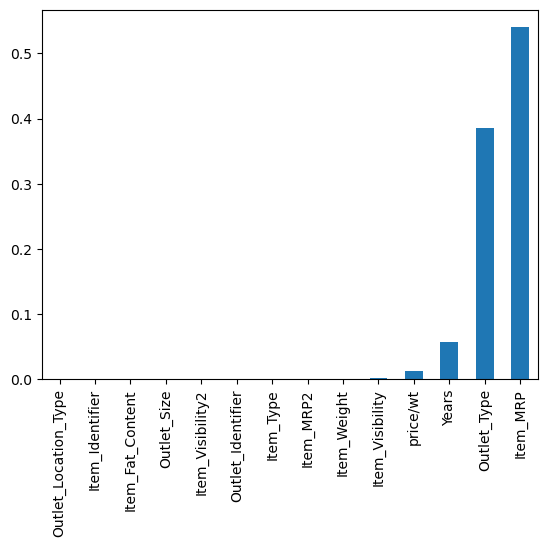

In [49]:
importance=pd.Series(model.feature_importances_,x.columns).sort_values().plot(kind='bar')

In [51]:
from sklearn.ensemble import GradientBoostingRegressor
# Train base models
rf_model = RandomForestRegressor(max_depth=6,n_estimators=41,random_state=1,min_samples_split=2,min_samples_leaf=3)
lr_model = GradientBoostingRegressor(max_depth=5,n_estimators=70,random_state=1,min_samples_split=2,min_samples_leaf=3,learning_rate=0.05,subsample=0.8,alpha=0.9)

rf_model.fit(xtr, ytr)
lr_model.fit(xtr, ytr)

# Make predictions
rf_pred = rf_model.predict(xvl)
lr_pred = lr_model.predict(xvl)

# Stack predictions
stacked_predictions = np.column_stack((rf_pred, lr_pred))

# Train meta-model
meta_model = RandomForestRegressor(max_depth=6,n_estimators=41,random_state=1,min_samples_split=2,min_samples_leaf=3)
meta_model.fit(stacked_predictions, yvl)

# Make final prediction
final_predictions = meta_model.predict(stacked_predictions)

# Evaluate final model
final_rmse = MSE(yvl, final_predictions, squared=False)
print("Final RMSE:", final_rmse)


Final RMSE: 987.2953595449414


In [973]:
rf_pred = rf_model.predict(test)
lr_pred = lr_model.predict(test)
stacked_predictions = np.column_stack((rf_pred, lr_pred))
pred_test=meta_model.predict(stacked_predictions)
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('RandomFGBMensembled.csv',index=False) # we got rmse 1204

In [129]:
from sklearn.neighbors import KNeighborsRegressor as KNN
model=KNN(n_neighbors=5)
model.fit(train_x,train_y)
predict_val=model.predict(val_x)
rmse=MSE(val_y,predict_val,squared=False)
rmse

1201.355269704069

In [131]:
def elbow(K):
    test_error=[]
    for i in K:
        model=KNN(n_neighbors=i)
        model.fit(train_x,train_y)
        tmp=model.predict(val_x)
        rmse=MSE(val_y,tmp,squared=False)
        test_error.append(rmse)
    return test_error


Text(0, 0.5, 'rmse')

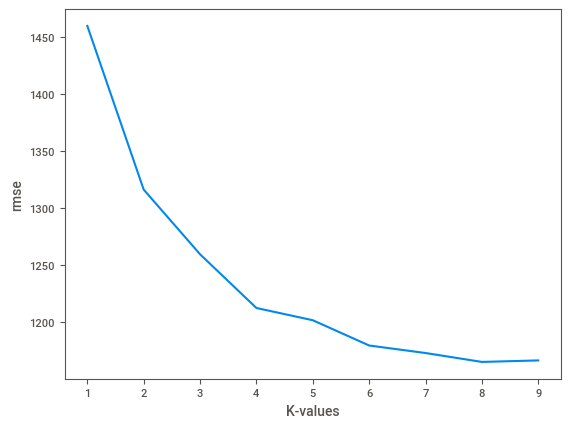

In [133]:
K=range(1,10)
test=elbow(K)
plt.plot(K,test)
plt.xlabel('K-values')
plt.ylabel('rmse') 

In [134]:
from sklearn.neighbors import KNeighborsRegressor as KNN
model=KNN(n_neighbors=8)
model.fit(train_x,train_y)
predict_val=model.predict(val_x)
rmse=MSE(val_y,predict_val,squared=False)
rmse  #still random forest scores are better so we are not going to use this model

1164.7809221154318

In [151]:
from sklearn.ensemble import AdaBoostRegressor
base_estimator=DecisionTreeRegressor(max_depth=6,random_state=1,min_samples_split=2,min_samples_leaf=3)
model=AdaBoostRegressor(base_estimator,n_estimators=21,learning_rate=0.1,random_state=1)
model.fit(train_x,train_y)
pred_val=model.predict(val_x)
rmse=MSE(val_y,predict_val,squared=False)
rmse

1164.7809221154318

In [164]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
i=1
score=[]
kf = KFold(n_splits=5,random_state=1,shuffle=True) # splitting the ds into 5 folds
for x_index,test_index in kf.split(x,y):#kf.split generates indices for different folds and stored in train_index and test_index
        print('n-{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = x.iloc[x_index],x.iloc[test_index]#splitting data into train and validation sets
        ytr,yvl = y.iloc[x_index],y.iloc[test_index]
        model =AdaBoostRegressor(base_estimator,n_estimators=41,learning_rate=0.01,random_state=1)
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        rmse = MSE(yvl,pred_val,squared=False)
        print('RMSE Score',rmse)
        score.append(rmse)
        i+=1

print(sum(score)/len(score))

n-1 of kfold 5
RMSE Score 1093.0069036788714
n-2 of kfold 5
RMSE Score 1084.6479470640038
n-3 of kfold 5
RMSE Score 1090.8959203391069
n-4 of kfold 5
RMSE Score 1010.2461608018403
n-5 of kfold 5
RMSE Score 1112.460698979108
1078.2515261725862


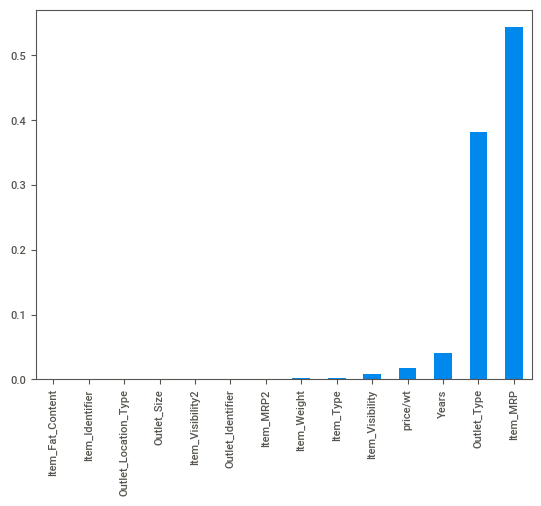

In [154]:
importance=pd.Series(model.feature_importances_,x.columns).sort_values().plot(kind='bar')

In [165]:
from sklearn.model_selection import KFold
base_estimator=RandomForestRegressor(max_depth=6,n_estimators=21,min_samples_split=2,min_samples_leaf=3)
i=1
score=[]
kf=KFold(n_splits=5,random_state=1,shuffle=True)
for x_index,test_index in kf.split(x,y):
    print(f'n-{i} of kfold {kf.n_splits}')
    xtr,xval=x.iloc[x_index],x.iloc[test_index]
    ytr,yval=y.iloc[x_index],y.iloc[test_index]
    model=AdaBoostRegressor(base_estimator,n_estimators=21,learning_rate=0.1,random_state=1)
    model.fit(xtr, ytr)
    pred_val = model.predict(xvl)
    rmse = MSE(yvl,pred_val,squared=False)
    print('RMSE Score',rmse)
    score.append(rmse)
    i+=1
    

n-1 of kfold 5
RMSE Score 1066.0243242424247
n-2 of kfold 5
RMSE Score 1068.906980999789
n-3 of kfold 5
RMSE Score 1069.2203767162146
n-4 of kfold 5
RMSE Score 1070.4420948422362
n-5 of kfold 5
RMSE Score 1116.292818745048


In [166]:
sum(score)/len(score)

1078.1773191091424

In [184]:
pred_test=model.predict(test)
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('AdaBoostReg.csv',index=False) # we got rmse 1558

In [468]:
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.15,random_state=42)

In [599]:
from catboost import CatBoostRegressor, Pool
categorical_features =  np.where(x.dtypes == object )[0]

def objective(trial,data=x,target=y):
    
    
    param = {
        'loss_function': 'RMSE',
        #'task_type': 'GPU',
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10.0), #log uniform distribution
        'max_bin': trial.suggest_int('max_bin', 200, 400), #integer values
        #'rsm': trial.suggest_uniform('rsm', 0.3, 1.0), #uniform distributiom
        'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0), 
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.01),
        'n_estimators':  1000,
        'max_depth': trial.suggest_categorical('max_depth',[5, 7, 9, 11, 13, 15]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        
    }
    model = CatBoostRegressor(**param,cat_features=categorical_features)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=200,verbose=False)
     
    preds = model.predict(test_x)
    
    rmse = MSE(test_y, preds,squared=False)
    
    return rmse

In [600]:
study = optuna.create_study(direction='minimize') #loss fun=rmse so shld minimize error
study.optimize(objective, n_trials=5)

[I 2024-04-09 09:48:07,986] A new study created in memory with name: no-name-a083d970-25ef-4dc4-9e48-563d9bdf2ae8
[I 2024-04-09 09:48:50,940] Trial 0 finished with value: 1026.208304807745 and parameters: {'l2_leaf_reg': 0.015864406740103823, 'max_bin': 267, 'bagging_fraction': 0.7248014063007708, 'learning_rate': 0.008548840726275861, 'max_depth': 5, 'random_state': 2020, 'min_data_in_leaf': 155}. Best is trial 0 with value: 1026.208304807745.
[I 2024-04-09 09:49:29,486] Trial 1 finished with value: 1026.9054817735607 and parameters: {'l2_leaf_reg': 0.40152261371877046, 'max_bin': 248, 'bagging_fraction': 0.767293860762088, 'learning_rate': 0.006511841305731981, 'max_depth': 5, 'random_state': 2020, 'min_data_in_leaf': 161}. Best is trial 0 with value: 1026.208304807745.
[I 2024-04-09 09:50:46,946] Trial 2 finished with value: 1025.610503147415 and parameters: {'l2_leaf_reg': 1.2703925811969124e-05, 'max_bin': 288, 'bagging_fraction': 0.4154931008034683, 'learning_rate': 0.00655276196

In [601]:
best_trial=study.best_trial.params
best_trial

{'l2_leaf_reg': 1.638008613180022e-05,
 'max_bin': 384,
 'bagging_fraction': 0.4608798602388981,
 'learning_rate': 0.007883996205601452,
 'max_depth': 9,
 'random_state': 2020,
 'min_data_in_leaf': 267}

In [602]:
if 'bagging_fraction' in best_trial:
    del best_trial['bagging_fraction']
from catboost import CatBoostRegressor
model=CatBoostRegressor(**best_trial)
model.fit(train_x,train_y,categorical_features)
pred=model.predict(test_x)
MSE(test_y,pred,squared=False)

0:	learn: 1703.3905440	total: 108ms	remaining: 1m 47s
1:	learn: 1695.6434106	total: 223ms	remaining: 1m 51s
2:	learn: 1687.9728739	total: 319ms	remaining: 1m 45s
3:	learn: 1680.5387437	total: 408ms	remaining: 1m 41s
4:	learn: 1673.2343083	total: 494ms	remaining: 1m 38s
5:	learn: 1666.5400316	total: 565ms	remaining: 1m 33s
6:	learn: 1659.2342650	total: 635ms	remaining: 1m 30s
7:	learn: 1652.1658907	total: 683ms	remaining: 1m 24s
8:	learn: 1645.1736442	total: 719ms	remaining: 1m 19s
9:	learn: 1638.1793174	total: 807ms	remaining: 1m 19s
10:	learn: 1631.3977990	total: 857ms	remaining: 1m 17s
11:	learn: 1625.0541189	total: 896ms	remaining: 1m 13s
12:	learn: 1618.3409069	total: 963ms	remaining: 1m 13s
13:	learn: 1611.9353554	total: 1.05s	remaining: 1m 13s
14:	learn: 1605.2416827	total: 1.18s	remaining: 1m 17s
15:	learn: 1598.5378928	total: 1.3s	remaining: 1m 20s
16:	learn: 1591.9104428	total: 1.4s	remaining: 1m 20s
17:	learn: 1585.6306731	total: 1.44s	remaining: 1m 18s
18:	learn: 1579.210176

1027.50829864204

In [538]:
pred_test=model.predict(test)
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('Optuna3.csv',index=False) # we got rmse 1152

In [467]:
item_visibility_mean=x['Item_Visibility'].mean()
x['item_Visibility_mean_ratio']=x['Item_Visibility']/item_visibility_mean
item_visibility_mean=test['Item_Visibility'].mean()
test['item_Visibility_mean_ratio']=test['Item_Visibility']/item_visibility_mean

In [470]:
if 'bagging_fraction' in best_trial:
    del best_trial['bagging_fraction']
from catboost import CatBoostRegressor
model=CatBoostRegressor(**best_trial)
model.fit(train_x,train_y,categorical_features)
pred=model.predict(test_x)
MSE(test_y,pred,squared=False)

0:	learn: 1697.5023166	total: 125ms	remaining: 2m 4s
1:	learn: 1684.0564639	total: 287ms	remaining: 2m 23s
2:	learn: 1670.7652511	total: 405ms	remaining: 2m 14s
3:	learn: 1657.9468029	total: 484ms	remaining: 2m
4:	learn: 1645.3540672	total: 620ms	remaining: 2m 3s
5:	learn: 1633.0649819	total: 709ms	remaining: 1m 57s
6:	learn: 1620.9345727	total: 833ms	remaining: 1m 58s
7:	learn: 1609.4995008	total: 994ms	remaining: 2m 3s
8:	learn: 1598.5696204	total: 1.12s	remaining: 2m 2s
9:	learn: 1587.6174061	total: 1.18s	remaining: 1m 56s
10:	learn: 1576.2910766	total: 1.31s	remaining: 1m 57s
11:	learn: 1565.3190114	total: 1.38s	remaining: 1m 53s
12:	learn: 1554.6581287	total: 1.47s	remaining: 1m 51s
13:	learn: 1544.1105191	total: 1.59s	remaining: 1m 52s
14:	learn: 1534.0784715	total: 1.68s	remaining: 1m 50s
15:	learn: 1523.8628651	total: 1.78s	remaining: 1m 49s
16:	learn: 1514.6869357	total: 1.9s	remaining: 1m 49s
17:	learn: 1505.0622065	total: 1.98s	remaining: 1m 47s
18:	learn: 1495.6430011	total

1030.443952316327

In [471]:
pred_test=model.predict(test)
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('new.csv',index=False) # we got rmse 1155

<Axes: >

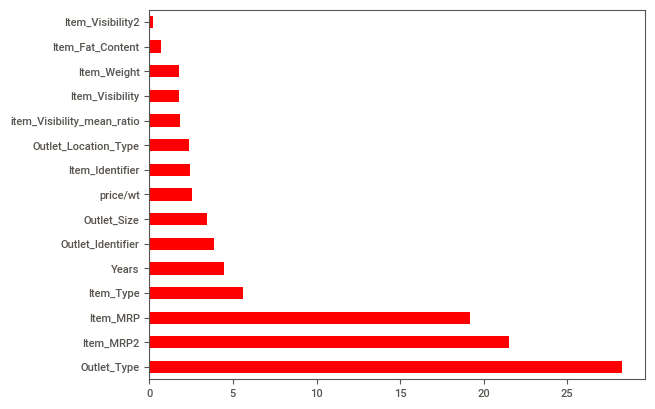

In [479]:
pd.Series(model.feature_importances_,x.columns).sort_values(ascending=False).plot(kind='barh',color='red')

In [526]:
optuna.visualization.plot_optimization_history(study)

In [614]:
x1=x.copy()
x1['Item_Type']=x1['Item_Type'].map({'Dairy':'Healthy','Soft Drinks':'Unhealthy','Meat':'Unhealthy','Fruits and Vegetables':'Healthy', 'Household':'Healthy'
                     ,'Baking Goods':'Unhealthy','Snack Foods':'Unhealthy','Frozen Foods':'Unhealthy','Breakfast':'Healthy','Health and Hygiene':'Healthy',
                     'Hard Drinks':'Unhealthy','Canned':'Unhealthy','Breads':'Healthy','Starchy Foods':'Healthy','Others':'Others','Seafood':'Healthy'})
x1

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0                 FD        9.300               LF         0.016047   
1                 DR        5.920                R         0.019278   
2                 FD       17.500               LF         0.016760   
3                 FD       19.200                R         0.070482   
4                 NC        8.930               LF         0.070482   
...              ...          ...              ...              ...   
8518              FD        6.865               LF         0.056783   
8519              FD        8.380                R         0.046982   
8520              NC       10.600               LF         0.035186   
8521              FD        7.210                R         0.145221   
8522              DR       14.800               LF         0.044878   

      Item_Type  Item_MRP Outlet_Identifier Outlet_Size Outlet_Location_Type  \
0       Healthy  249.8092            OUT049      Medium               Tier 1   
1     Unhealthy   48.2692            OUT018      Medium               Tier 3   
2     Unhealthy  141.6180            OUT049      Medium               Tier 1   
3       Healthy  182.0950            OUT010       Small               Tier 3   
4       Healthy   53.8614            OUT013        High               Tier 3   
...         ...       ...               ...         ...                  ...   
8518  Unhealthy  214.5218            OUT013        High               Tier 3   
8519  Unhealthy  108.1570            OUT045      Medium               Tier 2   
8520    Healthy   85.1224            OUT035       Small               Tier 2   
8521  Unhealthy  103.1332            OUT018      Medium               Tier 3   
8522  Unhealthy   75.4670            OUT046       Small               Tier 1   

            Outlet_Type  Years   price/wt Item_MRP2  Item_Visibility2  \
0     Supermarket Type1     14  26.861204         D                 1   
1     Supermarket Type2      4   8.153581         A                 1   
2     Supermarket Type1     14   8.092457         C                 1   
3         Grocery Store     15   9.484115         C                 0   
4     Supermarket Type1     26   6.031512         A                 0   
...                 ...    ...        ...       ...               ...   
8518  Supermarket Type1     26  31.248623         D                 1   
8519  Supermarket Type1     11  12.906563         B                 1   
8520  Supermarket Type1      9   8.030415         B                 1   
8521  Supermarket Type2      4  14.304189         B                 1   
8522  Supermarket Type1     16   5.099122         B                 1   

      item_Visibility_mean_ratio  
0                       0.227680  
1                       0.273520  
2                       0.237793  
3                       1.000000  
4                       1.000000  
...                          ...  
8518                    0.805646  
8519                    0.666589  
8520                    0.499225  
8521                    2.060398  
8522                    0.636735  

[8523 rows x 15 columns]

In [622]:
test1=test.copy()
test1['Item_Type']=test1['Item_Type'].map({'Dairy':'Healthy','Soft Drinks':'Unhealthy','Meat':'Unhealthy','Fruits and Vegetables':'Healthy', 'Household':'Healthy'
                     ,'Baking Goods':'Unhealthy','Snack Foods':'Unhealthy','Frozen Foods':'Unhealthy','Breakfast':'Healthy','Health and Hygiene':'Healthy',
                     'Hard Drinks':'Unhealthy','Canned':'Unhealthy','Breads':'Healthy','Starchy Foods':'Healthy','Others':'Others','Seafood':'Healthy'})

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0                 FD     20.75000               LF         0.007565   
1                 FD      8.30000                R         0.038428   
2                 NC     14.60000               LF         0.099575   
3                 FD      7.31500               LF         0.015388   
4                 FD     12.95504                R         0.118599   
...              ...          ...              ...              ...   
5676              FD     10.50000                R         0.013496   
5677              FD      7.60000                R         0.142991   
5678              NC     10.00000               LF         0.073529   
5679              FD     15.30000                R         0.070036   
5680              FD      9.50000                R         0.104720   

      Item_Type  Item_MRP Outlet_Identifier Outlet_Size Outlet_Location_Type  \
0     Unhealthy  107.8622            OUT049      Medium               Tier 1   
1       Healthy   87.3198            OUT017      Medium               Tier 2   
2        Others  241.7538            OUT010       Small               Tier 3   
3     Unhealthy  155.0340            OUT017      Medium               Tier 2   
4       Healthy  234.2300            OUT027      Medium               Tier 3   
...         ...       ...               ...         ...                  ...   
5676  Unhealthy  141.3154            OUT046       Small               Tier 1   
5677    Healthy  169.1448            OUT018      Medium               Tier 3   
5678    Healthy  118.7440            OUT045      Medium               Tier 2   
5679  Unhealthy  214.6218            OUT017      Medium               Tier 2   
5680  Unhealthy   79.7960            OUT045      Medium               Tier 2   

            Outlet_Type  Years   price/wt Item_MRP2  Item_Visibility2  \
0     Supermarket Type1     14   5.198178         B                 1   
1     Supermarket Type1      6  10.520458         B                 1   
2         Grocery Store     15  16.558479         D                 1   
3     Supermarket Type1      6  21.193985         C                 1   
4     Supermarket Type3     28  18.080222         D                 1   
...                 ...    ...        ...       ...               ...   
5676  Supermarket Type1     16  13.458610         C                 1   
5677  Supermarket Type2      4  22.255895         C                 1   
5678  Supermarket Type1     11  11.874400         B                 1   
5679  Supermarket Type1      6  14.027569         D                 0   
5680  Supermarket Type1     11   8.399579         B                 1   

      item_Visibility_mean_ratio  
0                       0.108014  
1                       0.548687  
2                       1.421774  
3                       0.219722  
4                       1.693413  
...                          ...  
5676                    0.192708  
5677                    2.041687  
5678                    1.049873  
5679                    1.000000  
5680                    1.495240  

[5681 rows x 15 columns]

In [935]:
train_x1,test_x1,train_y,test_y=train_test_split(x1,y,test_size=0.15,random_state=42)

In [770]:
x1['mrp/visibility']=x1['Item_MRP']/x1['Item_Visibility']
test1['mrp/visibility']=test1['Item_MRP']/test1['Item_Visibility']
x1['Item_Identifier']=x1['Item_Identifier'].map({'FD':'Food','DR':'Drink','NC':'Non-consumable'})
test1['Item_Identifier']=test1['Item_Identifier'].map({'FD':'Food','DR':'Drink','NC':'Non-consumable'})
x1['mean_mrp_Item_type']=x1.groupby(['Item_Type'])['Item_MRP'].transform(np.mean)
test1['mean_mrp_Item_type']=test1.groupby(['Item_Type'])['Item_MRP'].transform(np.mean)

In [918]:
best_trial

{'l2_leaf_reg': 1.638008613180022e-05,
 'max_bin': 384,
 'learning_rate': 0.007883996205601452,
 'max_depth': 9,
 'random_state': 2020,
 'min_data_in_leaf': 267}

In [936]:
if 'bagging_fraction' in best_trial:
    del best_trial['bagging_fraction']
from catboost import CatBoostRegressor
model=CatBoostRegressor(**best_trial)
model.fit(train_x1,train_y,categorical_features)
pred=model.predict(test_x1)
MSE(test_y,pred,squared=False)

0:	learn: 1703.8351034	total: 65.8ms	remaining: 1m 5s
1:	learn: 1696.1392049	total: 140ms	remaining: 1m 9s
2:	learn: 1688.5612719	total: 215ms	remaining: 1m 11s
3:	learn: 1681.1550238	total: 293ms	remaining: 1m 12s
4:	learn: 1673.7239861	total: 367ms	remaining: 1m 12s
5:	learn: 1666.3022710	total: 442ms	remaining: 1m 13s
6:	learn: 1658.9736369	total: 516ms	remaining: 1m 13s
7:	learn: 1651.8790179	total: 576ms	remaining: 1m 11s
8:	learn: 1644.5588861	total: 648ms	remaining: 1m 11s
9:	learn: 1637.8019153	total: 727ms	remaining: 1m 12s
10:	learn: 1630.7605032	total: 808ms	remaining: 1m 12s
11:	learn: 1623.9105705	total: 856ms	remaining: 1m 10s
12:	learn: 1617.0168938	total: 907ms	remaining: 1m 8s
13:	learn: 1610.3209197	total: 1.02s	remaining: 1m 11s
14:	learn: 1603.4857704	total: 1.1s	remaining: 1m 12s
15:	learn: 1596.7463573	total: 1.19s	remaining: 1m 12s
16:	learn: 1590.2171448	total: 1.27s	remaining: 1m 13s
17:	learn: 1583.7859627	total: 1.35s	remaining: 1m 13s
18:	learn: 1577.3014817

1024.9676851917613

In [937]:
pred_test=model.predict(test1)
pred_test[pred_test<33]=33 # some values are negtv so reaplacing them with minimum value 
submission['Item_Outlet_Sales']=pred_test
submission.to_csv('featureeng7.csv',index=False) # we got rmse 1149.06 and 537 rank on AV leaderboard.

<Axes: >

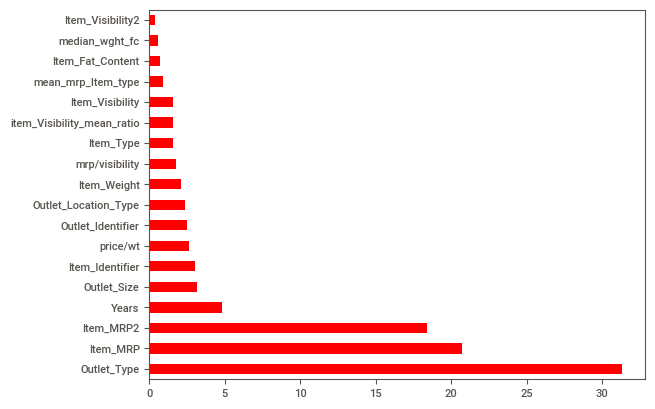

In [931]:
pd.Series(model.feature_importances_,x1.columns).sort_values(ascending=False).plot(kind='barh',color='r')

In [933]:
x1['median_wght_outlettyp']=x1.groupby('Outlet_Type')['Item_Weight'].transform(np.median)
test1['median_wght_outlettyp']=test1.groupby('Outlet_Type')['Item_Weight'].transform(np.median)